<a href="https://colab.research.google.com/github/Offliners/writeup/blob/main/HW6/homework6-5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 6 - Generative Adversarial Network**

This is the example code of homework 6 of the machine learning course by Prof. Hung-yi Lee.


In this homework, you are required to build a generative adversarial  network for anime face generation.


## Set up the environment


### Packages Installation

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!nvidia-smi

Mon May 10 18:02:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# You may replace the workspace directory if you want.
workspace_dir = './drive/MyDrive/HW6'

# Training progress bar
!pip install -q qqdm
!pip install stylegan2_pytorch

     |████████████████████████████████| 276kB 18.8MB/s 
     |████████████████████████████████| 163kB 25.8MB/s 
     |████████████████████████████████| 92kB 10.5MB/s 
     |████████████████████████████████| 153kB 28.3MB/s 
     |████████████████████████████████| 71kB 11.5MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 296kB 29.4MB/s 
     |████████████████████████████████| 163kB 50.3MB/s 
     |████████████████████████████████| 61kB 10.2MB/s 
     |████████████████████████████████| 71kB 11.4MB/s 
     |████████████████████████████████| 71kB 8.2MB/s 
  Created wheel for vector-quantize-pytorch: filename=vector_quantize_pytorch-0.1.0-cp37-none-any.whl size=2576 sha256=be0ea8788468e2c1638e91e9cf65eb2125a25f6e1c9bd27a1ea432d3c0806454
  Stored in directory: /root/.cache/pip/wheels/10/68/a9/2eb0d1f485a2babf71ac5e471c9d45703cf2a2cc8686f780d2
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115928 sha256=690dc28724e3df1

### Download the dataset
**Please use the link according to the last digit of your student ID first!**

If all download links fail, please follow [here](https://drive.google.com/drive/folders/13T0Pa_WGgQxNkqZk781qhc5T9-zfh19e).

* To open the file using your browser, use the link below (replace the id first!):
https://drive.google.com/file/d/REPLACE_WITH_ID
* e.g. https://drive.google.com/file/d/1IGrTr308mGAaCKotpkkm8wTKlWs9Jq-p

In [5]:
!gdown --id 1XpV2G-vOpCH72NU0aWRDToJQf6HbQeBX --output "./crypko_data.zip"
# Other download links
#   Please uncomment the line according to the last digit of your student ID first

# 0
# !gdown --id 131zPaVoi-U--XThvzgRfaxrumc3YSBd3 --output "{workspace_dir}/crypko_data.zip"

# 1
# !gdown --id 1kCuIj1Pf3T2O94H9bUBxjPBKb---WOmH --output "{workspace_dir}/crypko_data.zip"

# 2
# !gdown --id 1boEoiiqBJwoHVvjmI0xgoutE9G0Rv8CD --output "{workspace_dir}/crypko_data.zip"

# 3
# !gdown --id 1Ic0mktAQQvnNAnswrPHsg-u2OWGBXTWF --output "{workspace_dir}/crypko_data.zip"

# 4
# !gdown --id 1PFcc25r9tLE7OyQ-CDadtysNdWizk6Yg --output "{workspace_dir}/crypko_data.zip"

# 5
# !gdown --id 1wgkrYkTrhwDSMdWa5NwpXeE4-7JaUuX2 --output "{workspace_dir}/crypko_data.zip"

# 6
# !gdown --id 19gwNYWi9gN9xVL86jC3v8qqNtrXyq5Bf --output "{workspace_dir}/crypko_data.zip"

# 7 
# !gdown --id 1-KPZB6frRSRLRAtQfafKCVA7em0_NrJG --output "{workspace_dir}/crypko_data.zip"

# 8
# !gdown --id 1rNBfmn0YBzXuG5ub7CXbsGwduZqEs8hx --output "{workspace_dir}/crypko_data.zip"

# 9
# !gdown --id 113NEISX-2j6rBd1yyBx0c3_9nPIzSNz- --output "{workspace_dir}/crypko_data.zip"


Downloading...
From: https://drive.google.com/uc?id=1XpV2G-vOpCH72NU0aWRDToJQf6HbQeBX
To: /content/crypko_data.zip
452MB [00:13, 32.8MB/s]


###Unzip the downloaded file.
The unzipped tree structure is like 
```
faces/
├── 1.jpg
├── 2.jpg
├── 3.jpg
...
```

In [6]:
!unzip -q "./crypko_data.zip" -d "./"

## Random seed
Set the random seed to a certain value for reproducibility.

In [7]:
import random

import torch
import numpy as np


def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(0)

## Import Packages
First, we need to import packages that will be used later.

Like hw3, we highly rely on **torchvision**, a library of PyTorch.

In [8]:
import os
import glob

import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from qqdm.notebook import qqdm

# For SNGAN
from torch.nn.utils import spectral_norm

## Dataset
1. Resize the images to (64, 64)
1. Linearly map the values from [0, 1] to  [-1, 1].

Please refer to [PyTorch official website](https://pytorch.org/vision/stable/transforms.html) for details about different transforms.


In [9]:
class CrypkoDataset(Dataset):
    def __init__(self, fnames, transform):
        self.transform = transform
        self.fnames = fnames
        self.num_samples = len(self.fnames)

    def __getitem__(self,idx):
        fname = self.fnames[idx]
        # 1. Load the image
        img = torchvision.io.read_image(fname)
        # 2. Resize and normalize the images using torchvision.
        img = self.transform(img)
        return img

    def __len__(self):
        return self.num_samples


def get_dataset(root):
    fnames = glob.glob(os.path.join(root, '*'))
    # 1. Resize the image to (64, 64)
    # 2. Linearly map [0, 1] to [-1, 1]
    compose = [
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]
    transform = transforms.Compose(compose)
    dataset = CrypkoDataset(fnames, transform)
    return dataset

### Show some images
Note that the values are in the range of [-1, 1], we should shift them to the valid range, [0, 1], to display correctly.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


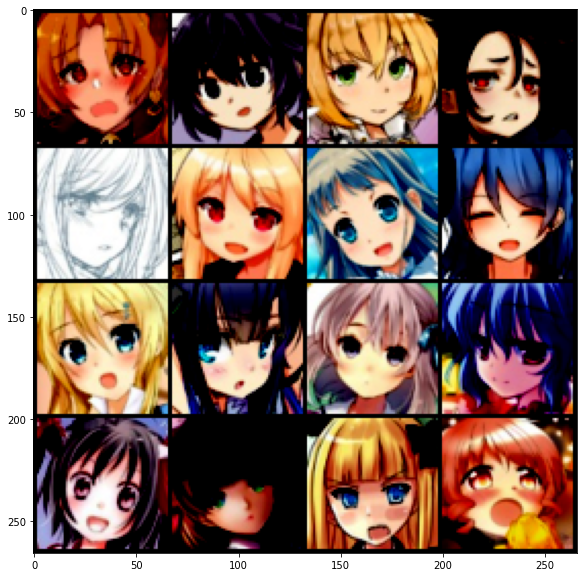

In [10]:
dataset = get_dataset(os.path.join('.', 'faces'))

images = [dataset[i] for i in range(16)]
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

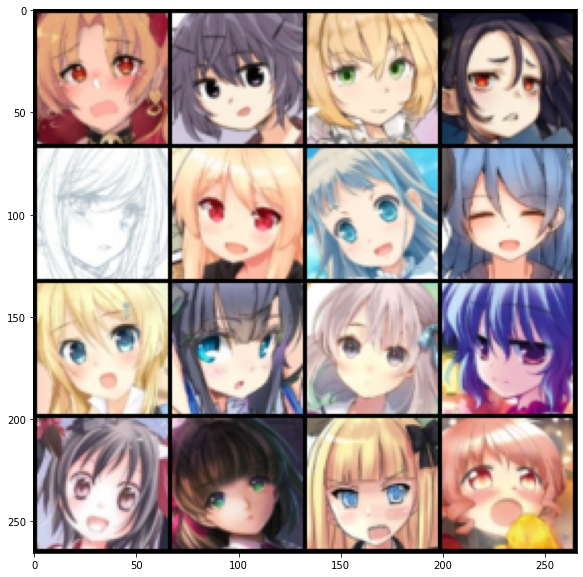

In [11]:
images = [(dataset[i]+1)/2 for i in range(16)]
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

## Model
Here, we use a simple CNN-based model structure. Feel free to modify your own model structure.

Note that the `N` of the input/output shape stands for the batch size.

## Training

In [ ]:
!stylegan2_pytorch --data faces --results_dir ./drive/MyDrive/HW6/stylegan --models_dir ./drive/MyDrive/HW6/stylegan --num-train-steps 100000 --image-size 64

default<faces>:   0% 0/100000 [00:00<?, ?it/s]G: 366.07 | D: 3.75 | GP: 7.96
default<faces>:   0% 45/100000 [00:42<27:08:46,  1.02it/s]G: -1.11 | D: 1.46 | GP: 1.91
default<faces>:   0% 93/100000 [01:24<25:07:07,  1.10it/s]G: 1.52 | D: 1.55 | GP: 0.04
default<faces>:   0% 141/100000 [02:07<24:48:48,  1.12it/s]G: 4.13 | D: 0.39 | GP: 0.60
default<faces>:   0% 189/100000 [02:50<24:32:43,  1.13it/s]G: 2.44 | D: 0.89 | GP: 0.29
default<faces>:   0% 249/100000 [03:43<24:34:47,  1.13it/s]G: 0.89 | D: 1.25 | GP: 12.84
default<faces>:   0% 297/100000 [04:26<24:27:38,  1.13it/s]G: 2.63 | D: 5.81 | GP: 5.81
default<faces>:   0% 345/100000 [05:09<24:36:49,  1.12it/s]G: 1.62 | D: 1.24 | GP: 1242.58
default<faces>:   0% 393/100000 [05:51<24:26:04,  1.13it/s]G: 2.63 | D: 0.36 | GP: 0.41
default<faces>:   0% 441/100000 [06:34<24:33:59,  1.13it/s]G: 2.23 | D: 1.65 | GP: 1.06
default<faces>:   0% 489/100000 [07:16<24:23:18,  1.13it/s]G: 6.51 | D: 0.42 | GP: 1.37
default<faces>:   1% 549/100000 [08:10<2

### Load model 

In [14]:
# !stylegan2_pytorch  --generate 10 --models_dir ./drive/MyDrive/HW6/stylegan/checkpoints --trunc-psi 0.5

In [15]:
# !stylegan2_pytorch --generate-interpolation --models_dir ./drive/MyDrive/HW6/stylegan/checkpoints --interpolation-num-steps 100

### Generate and show some images.


continuing from previous epoch - 50
loading from version 1.8.1


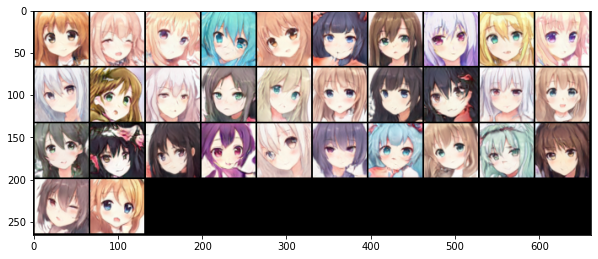

In [38]:
import torch
from torchvision.utils import save_image
from stylegan2_pytorch import ModelLoader

loader = ModelLoader(
    base_dir = './drive/MyDrive/HW6/stylegan/checkpoints',   # path to where you invoked the command line tool
    name = 'default'                   # the project name, defaults to 'default'
)

n_output = 1000
noise   = torch.randn(n_output, 512) # noise
styles  = loader.noise_to_styles(noise, trunc_psi = 0.1)  # pass through mapping network

imgs_sample = loader.styles_to_images(styles[:32])
grid_img = torchvision.utils.make_grid(imgs_sample.cpu(), nrow=10)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

### Compress the generated images using **tar**.


In [39]:
count = 0
os.makedirs('output', exist_ok=True)
for i in range(10):
    images = loader.styles_to_images(styles[i*100:(i+1)*100])
    for j in range(100):
        save_image(images[j], f'output/{count+1}.jpg') # save your images, or do whatever you desire
        count += 1

In [40]:
# Compress the images.
%cd output
!tar -zcf ../images.tgz *.jpg
%cd ..

from google.colab import files
files.download("images.tgz")

/content/output
/content


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Reference**

Source: Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW06/HW06.ipynb)

StyleGAN2 : https://github.com/lucidrains/stylegan2-pytorch